In [78]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np_  # Original numpy
import pennylane as qml
import scipy as sp

# Pennylane numpy
from pennylane import numpy as np 

In [79]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=1)

# Define Hamiltonian for quantum computations
coeffs = [-0.5]
obs = [qml.PauliZ(0)]
hamiltonian = qml.Hamiltonian(coeffs, obs)

In [80]:
# Global Parameters
Tau_global = 4   # Dephase tau
Paras_global = np.zeros(2)
Phi_global = 0
Gamma_ps = 8e-1

def Dephase_factor(tau):
    """
    Calculate the dephasing factor (gamma) based on the provided tau value.

    Args:
        tau (float): Dephasing time constant.

    Returns:
        float: Calculated dephasing factor (gamma).
    """
    return 1 - np.exp(-2 * tau)

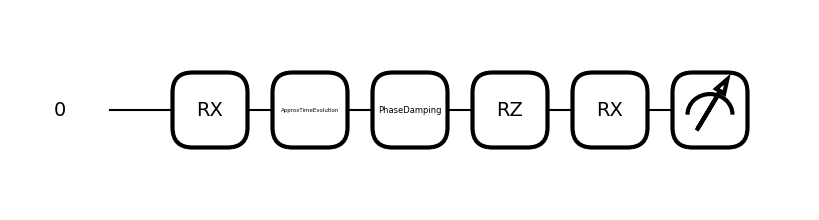

In [81]:
@qml.qnode(dev)
def circuit(paras):
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Set dephase factor 
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = paras

    qml.RX(np.pi/2, wires = 0)
    # qml.Hadamard(wires=0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)


@qml.qnode(dev)
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = 0)
    
    # Kraus operator for 2*2 matrix
    K = np.array([
        [np.sqrt(1 - Gamma_ps), 0],
        [0, 1]
    ])
    
    Numerator = K @ density_matrix @ K.conj().T
    Denominator = np.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

paras_plot = 1,1
fig, ax = qml.draw_mpl(circuit)(paras_plot)

In [82]:
PHI = np.arange(0, 12*np.pi, 1e-2)
DATA = np.zeros((4, len(PHI)))
DATA[0, :] = PHI
DATA[1, :] = np.pi/2

for phi_idx, phi in enumerate(PHI):
    N = int(phi/np.pi) * np.pi
    slope = ((2.9995 - 1.5707)/(1.42))
    if phi <= 1.5707 + N:
        DATA[2, phi_idx] = slope * (phi - N) + 1.5707
        
    elif 1.5707 + N <= phi and phi <= (1.5707 + np.pi) + N:
        DATA[2, phi_idx] = slope * (phi - 1.5707 - N) + 0 
        

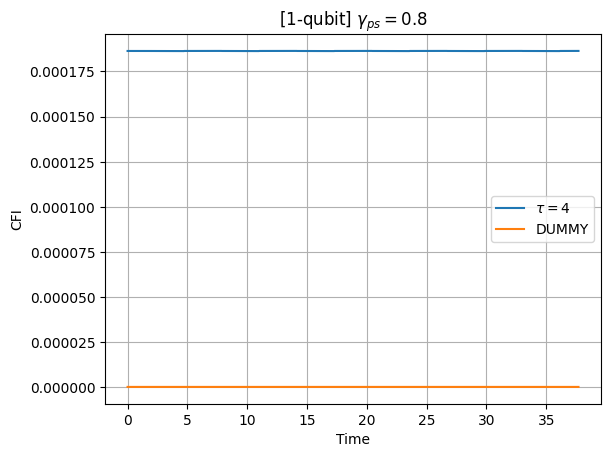

In [83]:
for phi_idx, phi in enumerate(PHI):
    Paras_global = DATA[1, phi_idx], DATA[2, phi_idx]
    DATA[3, phi_idx] = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi)
    
DUMMY = np.zeros(len(PHI))

plt.plot(DATA[0,:], DATA[3,:],label = f'$\\tau = {Tau_global}$')    
plt.plot(DATA[0,:], DUMMY, label = 'DUMMY')    
plt.title(f'[1-qubit] $\gamma_{{ps}} = {Gamma_ps}$')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

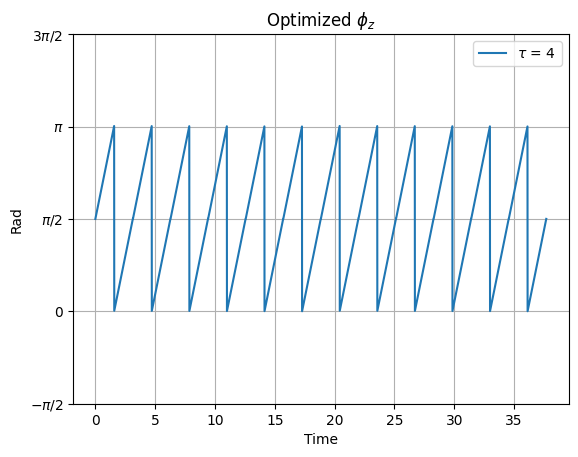

In [86]:
slice = int(len(PHI) / 1)

plt.plot(DATA[0,:slice], DATA[2,:slice], label = f'$\\tau$ = {Tau_global}')
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(-np.pi/2, 3*np.pi/2)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

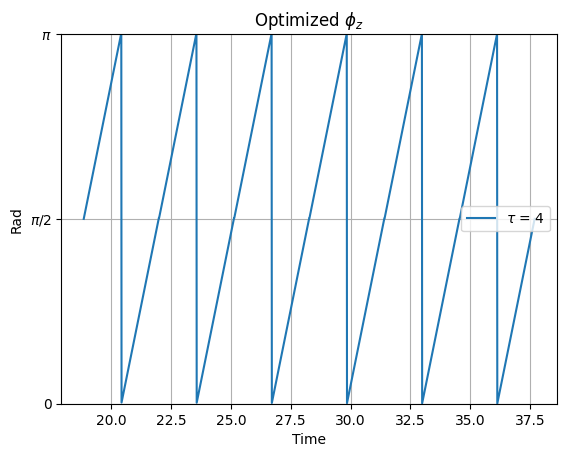

In [85]:
slice = int(len(PHI) / 2)


plt.plot(DATA[0,slice:], DATA[2,slice:], label = f'$\\tau$ = {Tau_global}')
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(0, 1*np.pi)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()